In [6]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim

from data_generation import generate_data
from models import OneHiddenRelu, SpikyModel, DeepRelu
from trainer import train_neural_model

# Expérience 1

L'objectif de cette expérience est de vérifier la consistance de la prédiction d'un réseau de neurones à une couche cachée très large avec la fonction d'activation spiky-smooth. 

Pour cela, nous allons créer n datasets chacun composé de couples $(X_i, Y_i)$ toujours tiré selon la même méthode. Les $X_i$ sont tirés selon une loi uniforme sur $[0, 1]$ et les $Y_i = cos(2 \pi \omega X_i) + N(0, \sigma^2)$. 

Ainsi, pour ces 10 datasets, nous allons estimer la variance et la MSE. 

A travers notre expérience, l'objectif est de voir si les objectifs de "benign overfitting" sont atteints. En effet, si le modèle peut overfit le bruit mais effectuer des prédictions en se "débarassant" du bruit, nous pourrons parler d'un overfitting bénin. Pour cela, nous nous attendons à observer très faible de notre estimateur. 

## Paramètres de l'expérience

In [7]:
# parameters for the generating trianing data 
n_datasets = 20  # nb of datasets to generate
n_points = 12  # nb of training data points
omega = 1.5  # freqeuncy of cosinus for train set
deterministic = True  # X_i deterministic or not
noise_scale = .5  # noise of data

# parameters for testing data
n_test_points = 50  # nb of test data points 

# parameters of models & training 
hidden_size = 2000  # size of hidden layer of spiky model
freq = 400  # freq of spiky-smooth actvation function 
num_epochs = 4000

## Generation des données 

In [8]:
# make a generator of datasets
def data_generator(n_points=n_points, n_datasets=n_datasets):
    for _ in range(n_datasets):
        yield generate_data(n_points, 
                            noise_scale=noise_scale, 
                            deterministic=deterministic, 
                            freq=omega)

## Début de l'expérience

In [3]:
# define testing points 
testing_points = np.linspace(0, 1, n_test_points).reshape(n_test_points, 1)
X_test = torch.tensor(testing_points, dtype=torch.float32)

# store value on testing points
relu_pred = np.zeros((n_datasets, n_test_points), dtype=np.float32)
spiky_pred = np.zeros((n_datasets, n_test_points), dtype=np.float32)

NameError: name 'np' is not defined

In [5]:
i = 0
for data in data_generator():

    # get data 
    X, y = data

    # define models
    relu_model = OneHiddenRelu(X.shape[-1], hidden_size=1000)
    spiky_model = SpikyModel(freq=freq, 
                             input_size=X.shape[-1], 
                             hidden_size=hidden_size, 
                             output_size=1)
    
    # train models 
    relu_model = train_neural_model(relu_model, X, y, num_epochs=num_epochs)
    spiky_model = train_neural_model(spiky_model, X, y, num_epochs=num_epochs)

    # make predictions 
    relu_pred[i, :] = relu_model(X_test).detach().numpy().T[0]
    spiky_pred[i, :] = spiky_model.inference(X_test).detach().numpy().T[0]

    # update 
    i += 1
    print(f"{i}/{n_datasets} iterations done.")


c:\Users\minoo\Desktop\Cours\3 - Theory of Deep Learning\papier a traiter\code\data_generation.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(np.cos(X * 2 * freq * np.pi) + noise, dtype=torch.float32)
c:\Users\minoo\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/20 iterations done.


c:\Users\minoo\Desktop\Cours\3 - Theory of Deep Learning\papier a traiter\code\data_generation.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(np.cos(X * 2 * freq * np.pi) + noise, dtype=torch.float32)


2/20 iterations done.
3/20 iterations done.
4/20 iterations done.
5/20 iterations done.
6/20 iterations done.
7/20 iterations done.
8/20 iterations done.
9/20 iterations done.
10/20 iterations done.
11/20 iterations done.
12/20 iterations done.
13/20 iterations done.
14/20 iterations done.
15/20 iterations done.
16/20 iterations done.
17/20 iterations done.
18/20 iterations done.
19/20 iterations done.
20/20 iterations done.


Nous pouvons maintenant évaluer la moyenne et la variance de chacune des deux méthodes en tous les points du dataset.

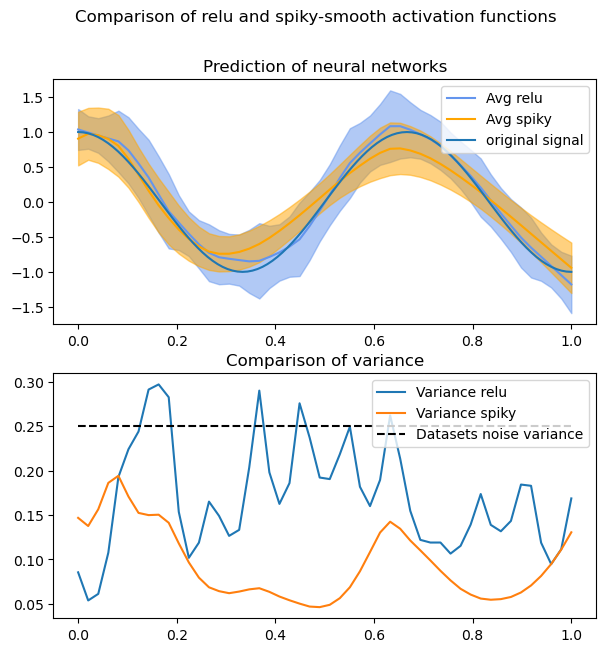

Moyenne ReLU :  0.051724054 , variance ReLU :  0.17035957
Moyenne Spiky :  0.04382875 , variance Spiky :  0.09523579


In [11]:
# compute mean at each point 
mean_relu = np.mean(relu_pred, axis=0)
mean_spiky = np.mean(spiky_pred, axis=0)

# compute variance at each point 
var_relu = np.var(relu_pred, axis=0)
var_spiky = np.var(spiky_pred, axis=0)

# add std on plot 
mean_relu_error_0 = mean_relu - np.sqrt(var_relu)
mean_relu_error_1 = mean_relu + np.sqrt(var_relu)
mean_spiky_error_0 = mean_spiky - np.sqrt(var_spiky)
mean_spiky_error_1 = mean_spiky + np.sqrt(var_spiky)

# construct theoretical signal 
x_ = np.linspace(0, 1., 100)
y_ = np.cos(x_ * 2 * omega * np.pi)

x = testing_points.reshape(len(testing_points))

# plot results 

fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ax[0].plot(testing_points, mean_relu, color="cornflowerblue", label="Avg relu")
ax[0].fill_between(x, mean_relu_error_0, mean_relu_error_1, color='cornflowerblue', alpha=0.5)
ax[0].plot(testing_points, mean_spiky, color="orange", label="Avg spiky")
ax[0].fill_between(x, mean_spiky_error_0, mean_spiky_error_1, color='orange', alpha=0.5)
ax[0].plot(x_, y_, label="original signal")
ax[0].set_title("Prediction of neural networks")

ax[1].plot(testing_points, var_relu, label="Variance relu")
ax[1].plot(testing_points, var_spiky, label="Variance spiky")
ax[1].hlines(0.25, xmin=0, xmax=1, linestyle='--', color="black", label="Datasets noise variance")
ax[1].set_title("Comparison of variance")

fig.suptitle("Comparison of relu and spiky-smooth activation functions")

ax[0].legend()
ax[1].legend()

plt.show()
print("Moyenne ReLU : ", np.mean(mean_relu), ", variance ReLU : ", np.mean(var_relu))
print("Moyenne Spiky : ", np.mean(mean_spiky), ", variance Spiky : ", np.mean(var_spiky))

Conclusion de cette première expérience: 

Nous avons donc entraîné deux réseaux de neurones sur 20 datasets différents mais de même signal à capturer jusqu'à overfitting. Idéalement, si spiky-relu permet un overfitting bénin, le signal prédit par ce réseau de neurones devrait toujours être le même (seul le bruit change dans les différentes expériences). Nous nous attendons donc deux choses. D'une part, que le signal prédit moyen par les deux réseaux de neurons (spiky-relu et relu) soient le bon signal. Le bruit étant gaussien, l'espérance des différentss signaux doivent être le signal d'origine. D'autre part, la variance du réseau "spiky-relu" doit être plus faible que celle du réseau relu. En effet, comme le réseau spiky-relu doit idéalement prédire toujours le même signal, sa variance théorique devrait être 0. 

Premièrement, nous pouvons observer sur le premier graphe que la moyenne des signaux est proche du signal à prédire. Cela montre que les deux réseaux de neurones ont capturé le bon signal. Cependant, on peut noter que l'espérance de spiky-relu est un peu moins bonne que relu et nécessite sans doute plus d'opitmisation de l'hyperparamètre "fréquence" de spiky-relu.

Deuxièmement, la variance du réseau spiky-relu est bien plus faible que celui avec relu. Cela montre un résultat que nous attendions. Spiky-relu est moins sensible au bruit et généralise bien: le signal extrait par spiky-relu est peu sensible au bruit. 

Nous écrivons ces deux paramètres à la suite des deux graphes. Pour la moyenne empirique, nous avons pris pour chaque point de discrétisation la moyenne sur toutes les expériences et nous avons moyenné sur tous les points de discrétisation, donc sur une période. Nous avons fait de même pour la variance. Finalement, l'objectif et de tendre vers 0 pour les deux statistiques. 

On pourra tout de même noter que nous avons eu besoin d'optmiser l'hyperparamètre de la fonction d'activation spiky-relu. Cela nous mène à la seconde expérience: l'influence de cet hyperparamètre sur l'overftitting bénin.

### Experience 2

In their experiment, they use as activation function : $act(x) = ReLU(x)+\omega(x;1500)$ with $w_{NTK}(x, \gamma) = \sqrt{\dfrac{\gamma}{2}}(sin(\sqrt{\dfrac{2}{\gamma}})+cos(\sqrt{\dfrac{2}{\gamma}}))$ thus $act(x)=0.01\cdot(sin(100x)+cos(100x))$

In [9]:
# parameters for the generating trianing data 
n_points = 20  # nb of training data points
omega = 1.5  # freqeuncy of cosinus for train set
deterministic = True  # X_i deterministic or not
noise_scale = np.sqrt(0.25)  # noise of data

# parameters for testing data
n_test_points = 50  # nb of test data points 

# parameters of models & training 
hidden_size = 10000  # size of hidden layer of spiky model
freq = [10, 50, 100, 200, 400, 1000, 2000, 4000]  # freq of spiky-smooth actvation function 
num_epochs = 4000

In [10]:
# define testing points 
testing_points = np.linspace(0, 1, n_test_points).reshape(n_test_points, 1)
X_test = torch.tensor(testing_points, dtype=torch.float32)

# store value on testing points
raw_pred = np.zeros((len(freq), n_test_points), dtype=np.float32)
signal_pred = np.zeros((len(freq), n_test_points), dtype=np.float32)

# generate data 
data = generate_data(n_points, 
                     noise_scale=noise_scale, 
                     deterministic=deterministic, 
                     freq=omega)

X, y = data

c:\Users\minoo\Desktop\Cours\3 - Theory of Deep Learning\papier a traiter\code\data_generation.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(np.cos(X * 2 * freq * np.pi) + noise, dtype=torch.float32)


In [11]:
i = 0
losses = []
for f in freq:

    # define models
    spiky_model = SpikyModel(freq=f, 
                             input_size=X.shape[-1], 
                             hidden_size=hidden_size, 
                             output_size=1)
    
    # train models 
    spiky_model, loss = train_neural_model(spiky_model, X, y, num_epochs=num_epochs, return_loss=True)
    losses.append(loss)

    # make predictions 
    raw_pred[i, :] = spiky_model(X_test).detach().numpy().T[0]
    signal_pred[i, :] = spiky_model.inference(X_test).detach().numpy().T[0]

    # update 
    i += 1
    print(f"{i}/{len(freq)} iterations done.")


c:\Users\minoo\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/8 iterations done.
2/8 iterations done.
3/8 iterations done.
4/8 iterations done.
5/8 iterations done.
6/8 iterations done.
7/8 iterations done.
8/8 iterations done.


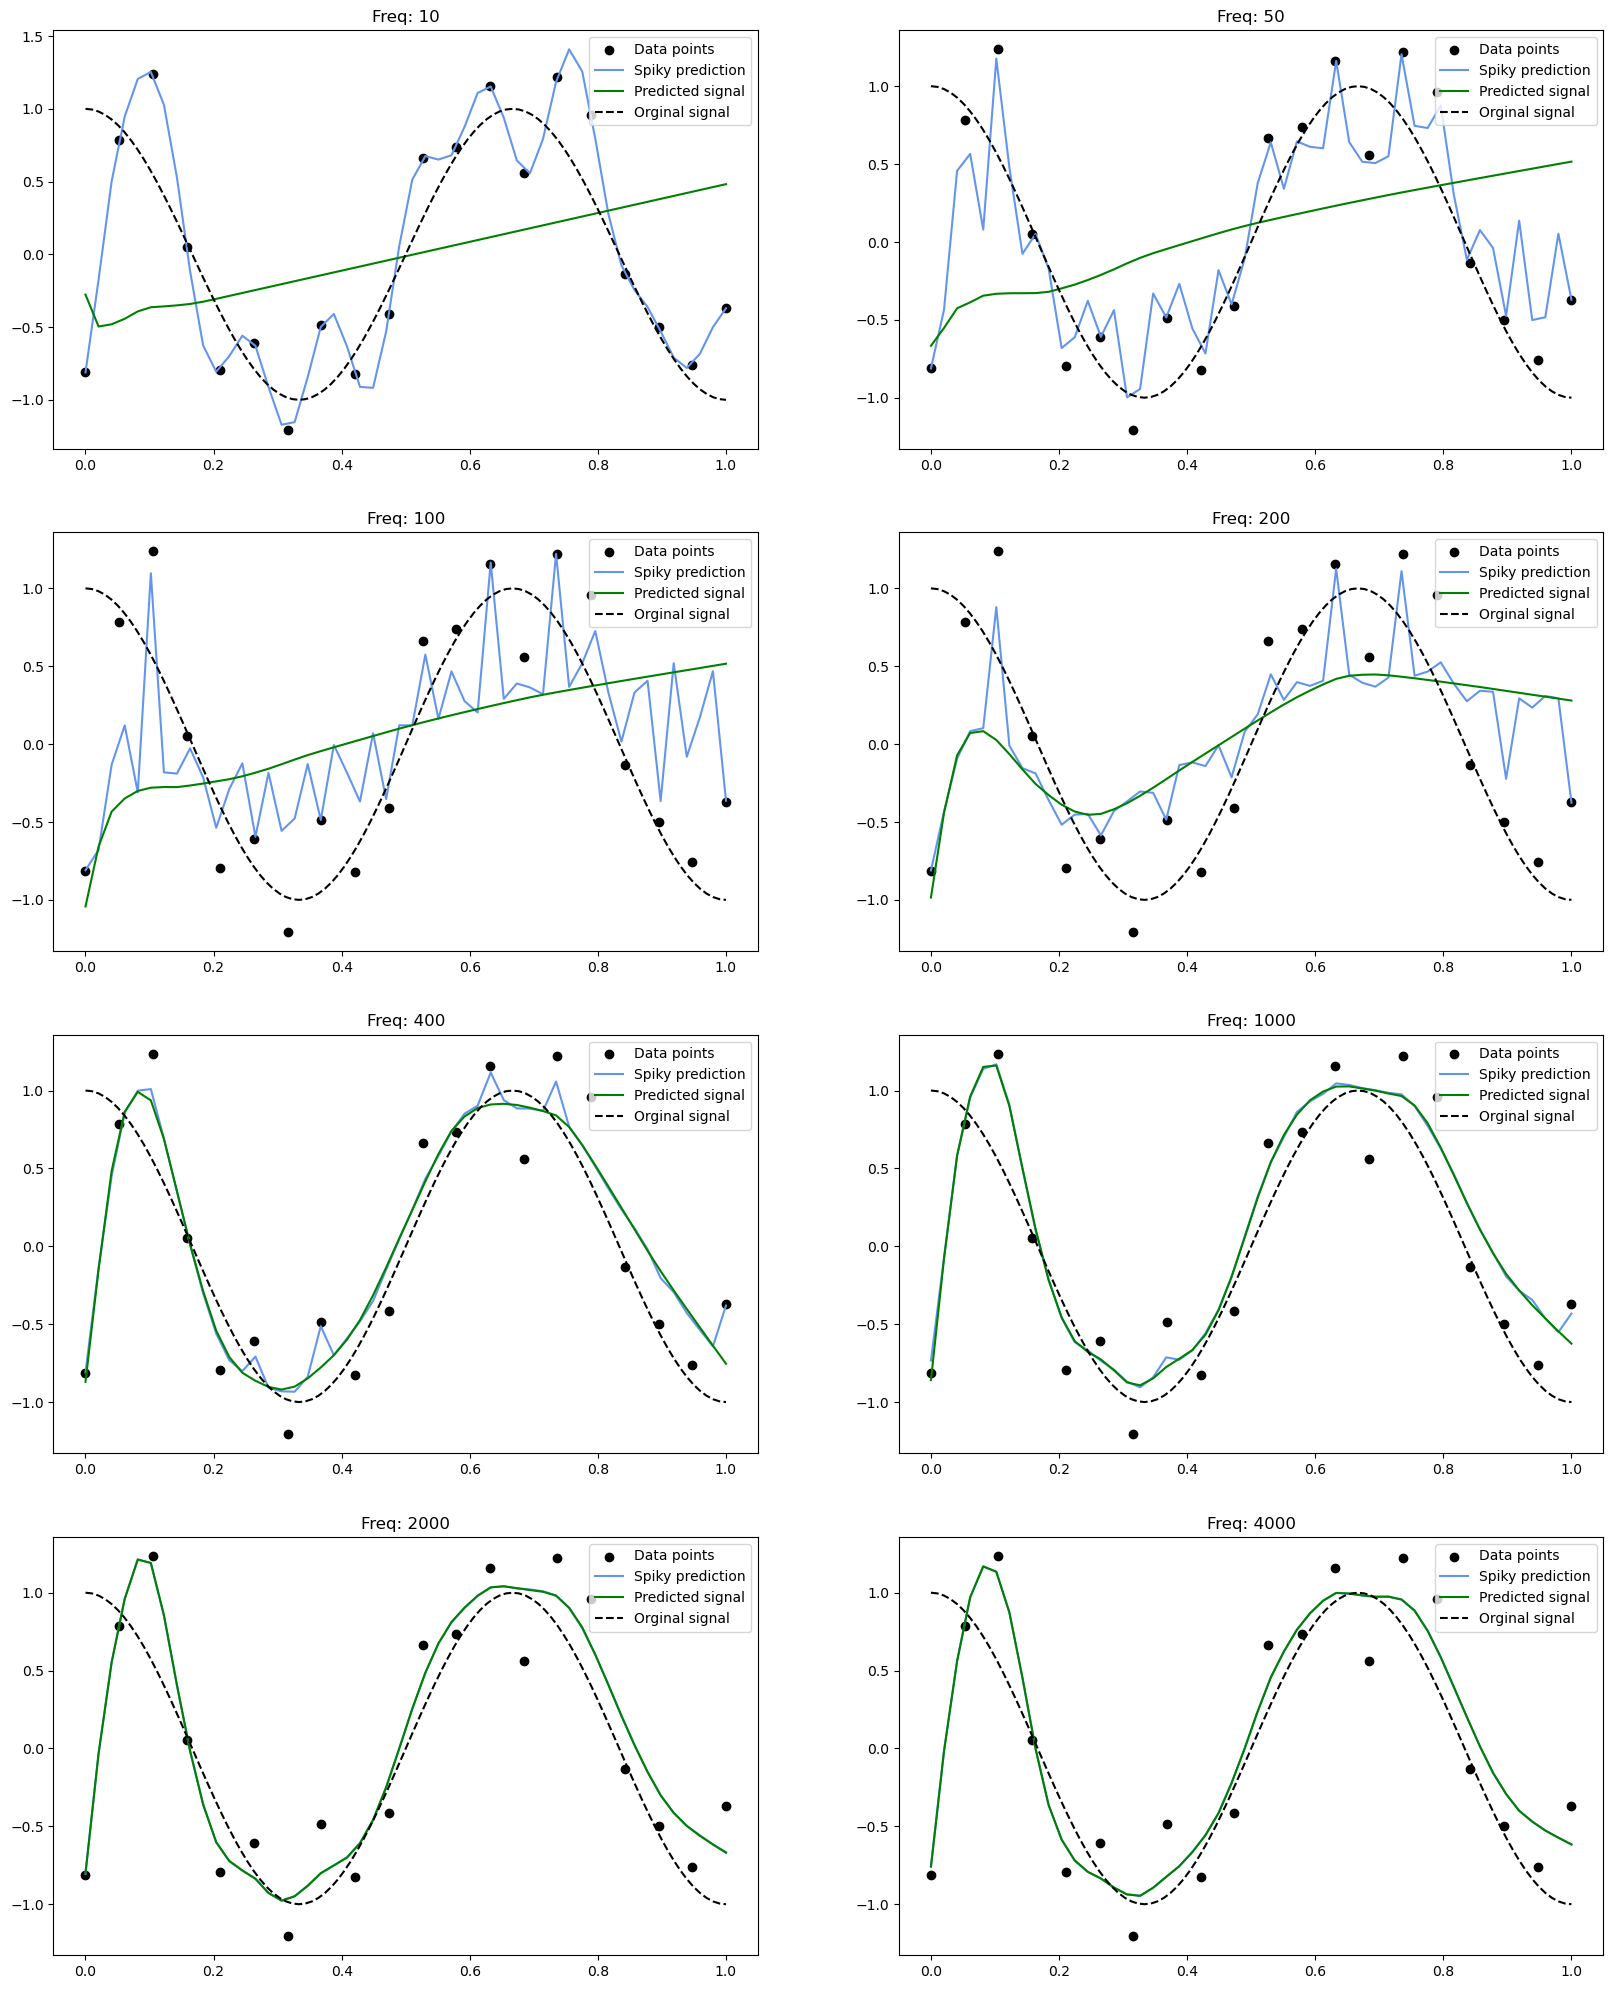

In [13]:
# construct theoretical signal 
x_ = np.linspace(0, 1., 100)
y_ = np.cos(x_ * 2 * omega * np.pi)

x = testing_points.reshape(len(testing_points))

fig, ax = plt.subplots(4, 2, figsize=(20, 25))

axis_ = [(i, j) for i in range(4) for j in range(2)]

for index, ax_index in enumerate(axis_):

    ax[ax_index].scatter(X, y, color="black", label="Data points")
    ax[ax_index].plot(x, raw_pred[index], color="cornflowerblue", label="Spiky prediction")
    ax[ax_index].plot(x, signal_pred[index], color="green", label="Predicted signal")
    ax[ax_index].plot(x_, y_, color="black", linestyle="--", label="Orginal signal")
    ax[ax_index].set_title(f"Freq: {freq[index]}")

    ax[ax_index].legend()

Nous traçons le signal vérité terrain en pointillés, les points d'entraînement ainsi que le spiky prediction et le signal prédit. Le spiky prediction est obtenu en prenant la sortie directe du modèle, c'est à dire $ReLU+\omega$. Le signal prédit est obtenu en enlevant $\omega$ et ne gardant que la composante $ReLU$

Nous voyons l'effect du surapprentissage pour la basse fréquence $10$.
Pour les fréquences $50$, $100$, $200$, nous remarquons le fait que le modèle aille chercher les points d'entraînement, ce qui n'est plus visible par la suite étant donné le facteur $\dfrac{1}{f}$ devant le $cos+sin$. 

De plus quand il y a surapprentissage, nous devrions nous attendre à obtenir une moyenne de signal de 0. Or, nous voyons une tendance à la hausse qui est dû à l'aléatoire et effets de bords.
 
Ce n'est néanmoins qu'à partir de la fréquence 400 que la courbe sinusoïdale est bien prédite. De plus, nous n'observons pas d'amélioration nette entre 400 et 4000. 

En outre, la fréquence $f=100$ correspond à celle de l'expérience du papier. Nous remarquons que ce n'est pas celle qui donne la meilleur prédiction. 

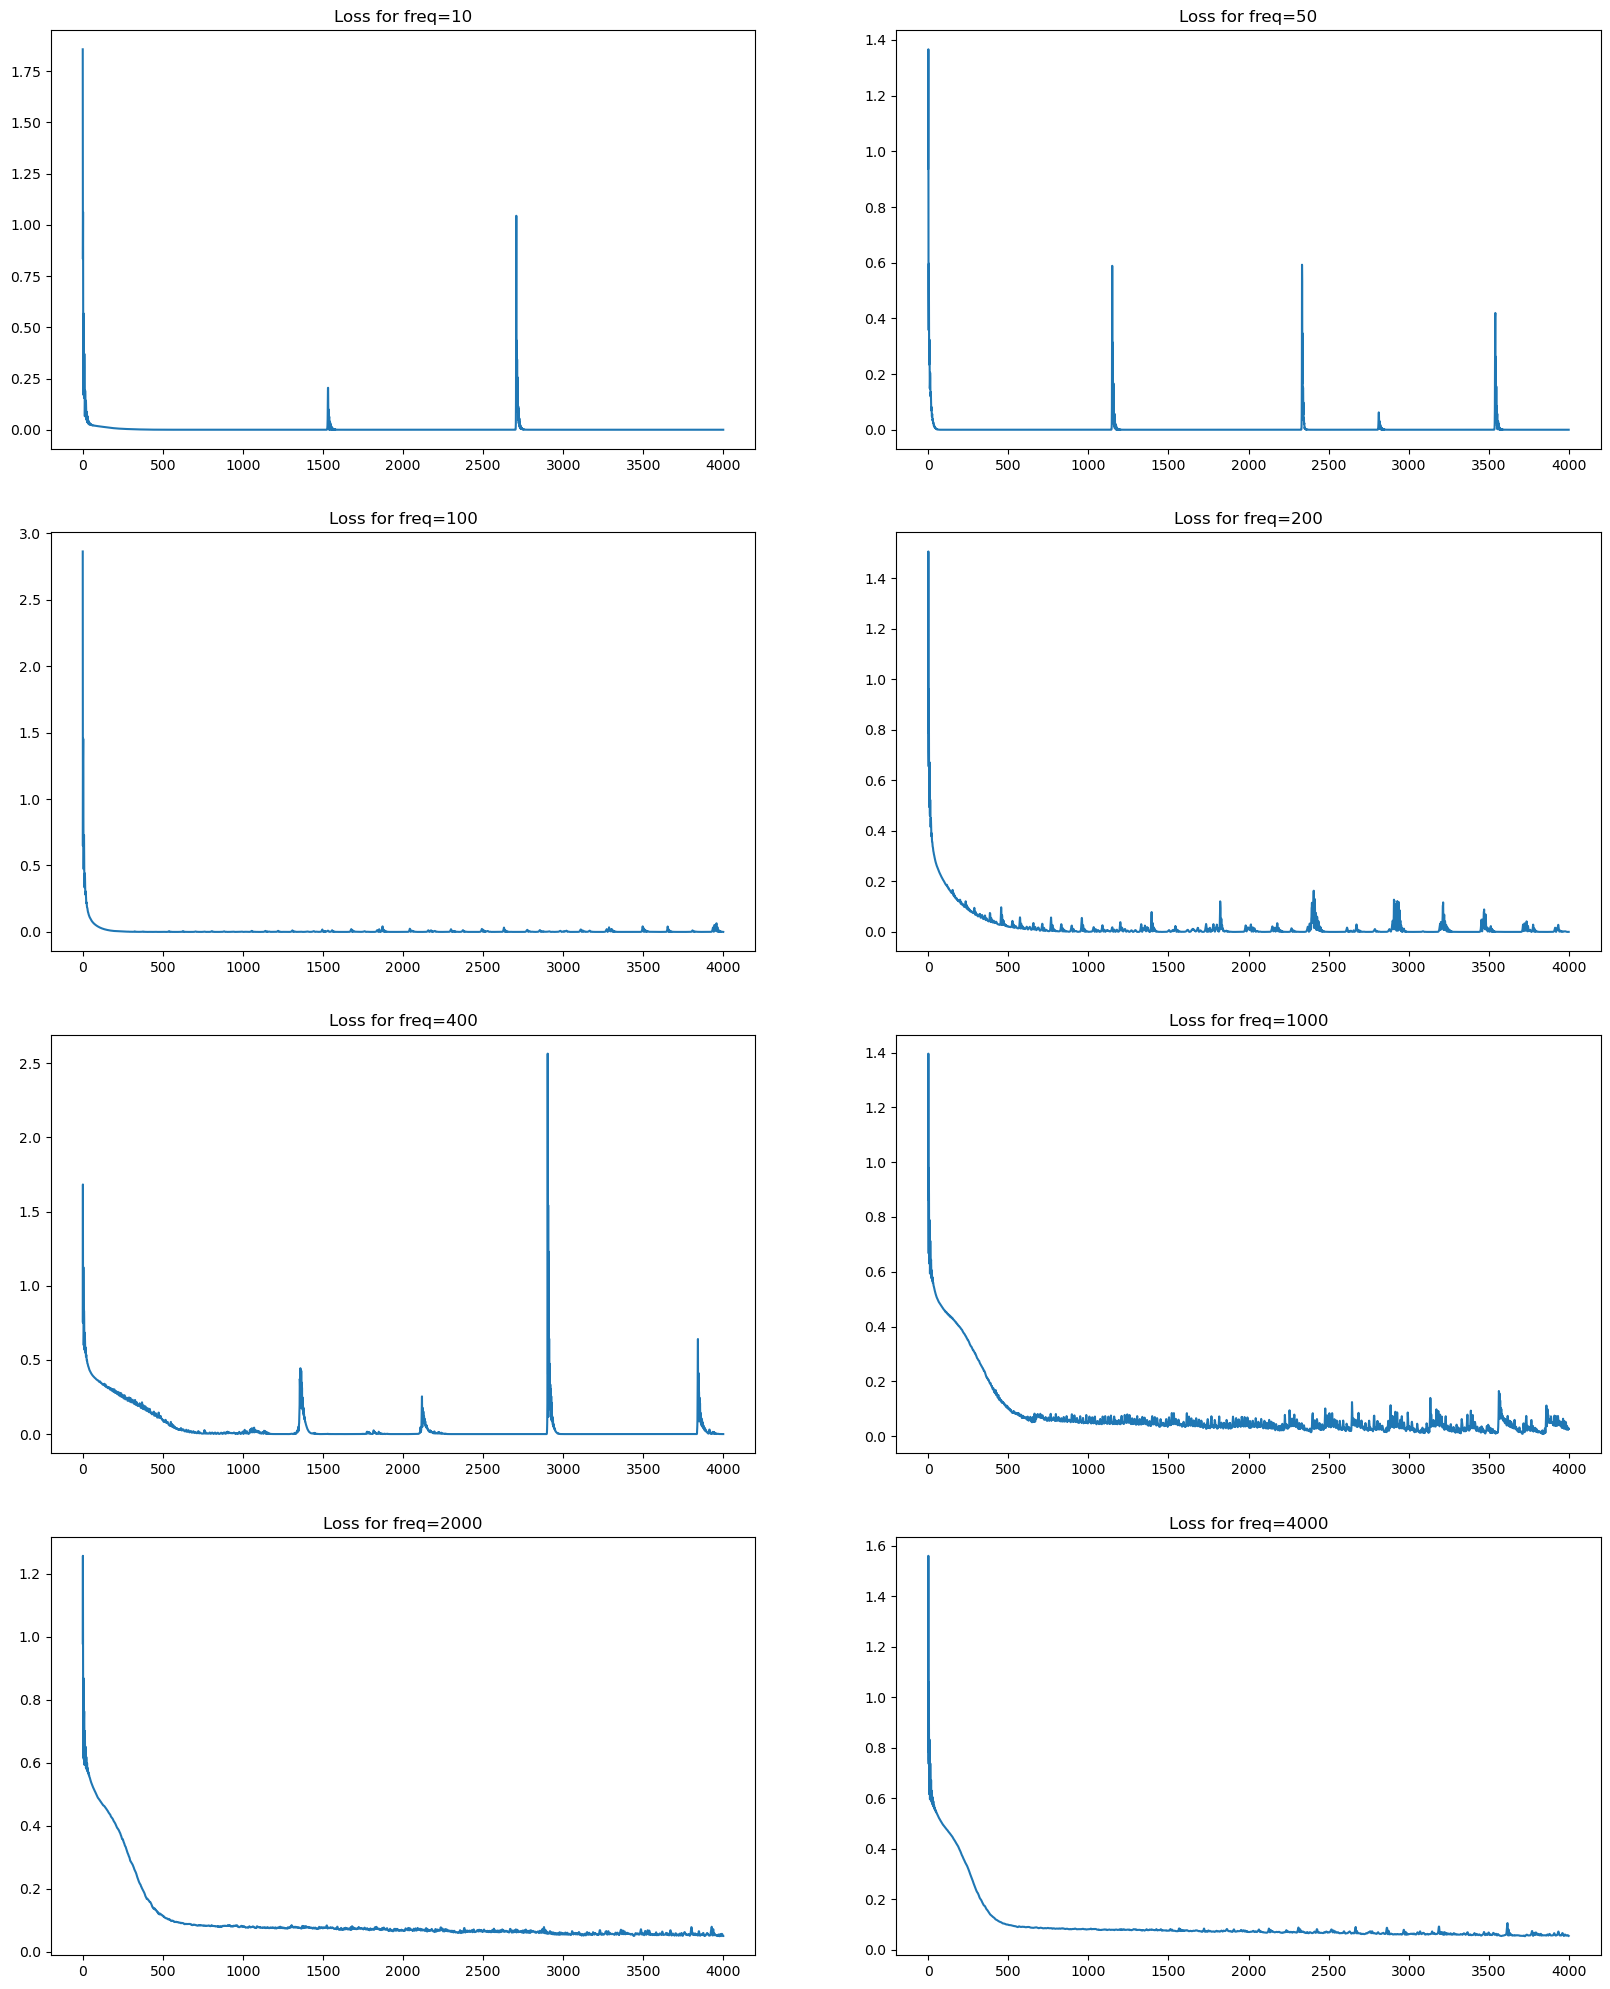

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(20, 25))
ax = ax.ravel()
for i, loss in enumerate(losses):
    ax[i].plot(loss)
    ax[i].set_title(f"Loss for freq={freq[i]}")

Nous avons également tracé la fonction de coût pour les différentes fréquences. Nous remarquons deux choses:
- La première est que pour des fréquences plus faibles, les courbes sont plus lissées que pour des fréquences plus élevées, mais les modèles convergent
- La deuxième est le saut de la courbe de temps en temps. 
Nous ne savons pas expliquer pourquoi ces résultats sont obtenus. 
